In [2]:
!pip install mariadb

   ---------------------------------------- 0.0/197.6 kB ? eta -:--:--
   -- ------------------------------------- 10.2/197.6 kB ? eta -:--:--
   ---------------- ----------------------- 81.9/197.6 kB 1.1 MB/s eta 0:00:01
   ---------------------------------------- 197.6/197.6 kB 2.0 MB/s eta 0:00:00


In [22]:
!pip install pyyaml

### Standard references

In [3]:
from datetime import datetime, timedelta
from typing import Any, Dict, List, Sequence, Tuple
from yaml import safe_load
from logging import INFO, Formatter, basicConfig, warning
from mariadb import Connection, Cursor

import re

### namespace: `utils`

In [6]:
DATETIME_FORMAT: str = "%Y-%m-%d %H:%M:%S"
TIMEZONE_DIFFERENCE: Dict[str, int] = {"hours": -3, "minutes": 0}

def brt_now() -> datetime:
    return datetime.utcnow() + timedelta(**TIMEZONE_DIFFERENCE)

class Settings(object):
    CONFIG: Dict[str, Any] = {}

    def __init__(self, *args: Tuple[Any, ...], **kwargs: Dict[str, Any]):
        raise SyntaxError("This is an utility class.")

    @staticmethod
    def load(path: str) -> None:
        with open(path, "r") as file:
            Settings.CONFIG = safe_load(file)

### namespace: `db`

In [9]:
class Report(object):
    def __init__(
        self,
        subsystem_id: str,
        instant_record: datetime | str,
        instant_load_following: float,
    ):
        self.__subsystem_id: str = subsystem_id
        self.__instant_record: datetime = datetime.min

        if isinstance(instant_record, datetime):
            self.__instant_record = instant_record
        else:
            try:
                self.__instant_record = datetime.strptime(
                    instant_record, DATETIME_FORMAT
                )
            except ValueError:
                self.__instant_record = datetime.strptime(
                    f"{instant_record} 00:00:00", DATETIME_FORMAT
                )

        self.__instant_load_following: float = instant_load_following

    @property
    def subsystem_id(self) -> str:
        return self.__subsystem_id

    @subsystem_id.setter
    def subsystem_id(self, value: str) -> None:
        self.__subsystem_id = value

    @property
    def instant_record(self) -> datetime:
        return self.__instant_record

    @instant_record.setter
    def instant_record(self, value: datetime) -> None:
        self.__instant_record = value

    @property
    def instant_load_following(self) -> float:
        return self.__instant_load_following

    @instant_load_following.setter
    def instant_load_following(self, value: float) -> None:
        self.__instant_load_following = value

    def serialize_data(self) -> Tuple[str, datetime, float]:
        return (
            self.__subsystem_id,
            self.__instant_record,
            self.__instant_load_following,
        )

    def to_json(self) -> Dict[str, Any]:
        return {
            "subsystem_id": self.__subsystem_id,
            "instant_record": self.__instant_record.strftime(DATETIME_FORMAT),
            "instant_load_following": self.__instant_load_following,
        }


class MariaDbUtils(object):
    def __init__(self, *args: Tuple[Any, ...]):
        raise SyntaxError("This is an utility class.")

    @staticmethod
    def add_report(report: Report) -> bool:
        with MariaDb() as mariadb:
            return mariadb.execute(
                query="""
                INSERT INTO `sin_subsystems_reports` (
                    `subsystem_id`, `instant_record`,
                    `instant_load_following`
                ) VALUES (?, ?, ?)
                """,
                data=report.serialize_data(),
            )

    @staticmethod
    def add_reports(reports: List[Report]) -> bool:
        with MariaDb() as mariadb:
            return mariadb.executemany(
                query="""
                INSERT INTO `sin_subsystems_reports` (
                    `subsystem_id`, `instant_record`,
                    `instant_load_following`
                ) VALUES (?, ?, ?)
                """,
                data=[report.serialize_data() for report in reports],
            )

    @staticmethod
    def is_empty_reports() -> bool:
        with MariaDb() as mariadb:
            cursor: Cursor = mariadb.execute(
                query="SELECT COUNT(`id`) FROM `sin_subsystems_reports`"
            )
            cursor_results: Tuple[int, ...] = cursor.fetchone()
            (count_reports,) = cursor_results
            return count_reports == 0
        
    @staticmethod
    def fetch_subsystem_name_by_id(subsystem_id: str) -> str:
        with MariaDb() as mariadb:
            cursor: Cursor = mariadb.execute(
                query="SELECT `name` FROM `sin_subsystems` WHERE `id`=?",
                data=(subsystem_id,),
            )
            cursor_results: Tuple[str, ...] = cursor.fetchone()
            if cursor_results.__len__() == 0:
                return None
            
            (subsystem_name,) = cursor_results
            return subsystem_name

    @staticmethod
    def fetch_reports_by_subsystem_id(subsystem_id: str) -> List[Report]:
        with MariaDb() as mariadb:
            cursor: Cursor = mariadb.execute(
                query="SELECT * FROM `sin_subsystems_reports` WHERE `subsystem_id`=?",
                data=(subsystem_id,),
            )
            for args in cursor:
                yield Report(*args[1:])

    @staticmethod
    def fetch_distinct_instant_record_years() -> List[int]:
        if MariaDbUtils.is_empty_reports():
            yield None

        with MariaDb() as mariadb:
            current_year: int = brt_now().year
            cursor: Cursor = mariadb.execute(
                query="SELECT DISTINCT YEAR(`instant_record`) FROM `sin_subsystems_reports`"
            )
            for (year,) in cursor:
                if year < current_year:
                    yield year

    @staticmethod
    def fetch_latest_instant_record() -> datetime:
        if MariaDbUtils.is_empty_reports():
            return datetime.min

        with MariaDb() as mariadb:
            cursor: Cursor = mariadb.execute(
                query="SELECT MAX(`instant_record`) FROM `sin_subsystems_reports`"
            )
            cursor_results: Tuple[datetime, ...] = cursor.fetchone()
            if cursor_results.__len__() == 0:
                return datetime.min

            (instant_record,) = cursor_results
            return instant_record


class MariaDb(object):
    def __init__(self):
        self.__db_connection: Connection = None

    def __enter__(self):
        try:
            self.__db_connection: Connection = Connection(**Settings.CONFIG["database"])
        except Exception as err:
            warning(f"Error connecting to MariaDB Platform: {err}", RuntimeWarning)
        return self

    def __exit__(self, *args: Tuple[Any, ...]) -> None:
        self.__db_connection.close()

    def execute(self, query: str, data: Sequence = ()) -> Cursor | bool:
        is_select_statement: bool = bool(re.match(r"^(select).*", query.lower()))
        db_cursor: Cursor = self.__db_connection.cursor()
        try:
            db_cursor.execute(query.strip(), data)
            if is_select_statement:
                return db_cursor
            else:
                return True
        except Exception as err:
            warning(
                f"Error while committing changes to database: {err}", RuntimeWarning
            )
            return False

    def executemany(self, query: str, data: List[Sequence]) -> bool:
        db_cursor: Cursor = self.__db_connection.cursor()
        try:
            db_cursor.executemany(query.strip(), data)
            return True
        except Exception as err:
            warning(
                f"Error while committing massive changes to database: {err}",
                RuntimeWarning,
            )
            return False

### namespace: `__init__::__main__()`

In [12]:
Settings.load("../settings.yaml")

log_fmt: Formatter = Formatter(
    "%(asctime)s,%(msecs)-3d - %(levelname)-8s => " "%(message)s"
)
log_config: Dict[str, Any] = {
    "format": vars(log_fmt).get("_fmt"),
    "datefmt": "%Y-%m-%d %H:%M:%S",
    "level": INFO,
}
basicConfig(**log_config)

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
import pandas as pd

In [16]:
SUBSYSTEM_ID: str = "N" # searching for  'North' subsystem on SIN
SUBSYSTEM_NAME: str = MariaDbUtils.fetch_subsystem_name_by_id(SUBSYSTEM_ID)

In [18]:
reports_by_subsystem_id: List[Report] = list(MariaDbUtils.fetch_reports_by_subsystem_id(SUBSYSTEM_ID))

In [20]:
reports_by_subsystem_id.__len__()

9150

In [22]:
df: pd.DataFrame = pd.DataFrame(
    [report.serialize_data() for report in reports_by_subsystem_id],
    columns=['subsystem_id', 'instant_record', 'instant_load_following']
)

In [24]:
df.head()

,subsystem_id,instant_record,instant_load_following
0,N,2000-01-01,2243.51
1,N,2000-01-02,2259.81
2,N,2000-01-03,2407.43
3,N,2000-01-04,2404.22
4,N,2000-01-05,2439.65


In [28]:
all_years: List[int] = df['instant_record'].dt.year.unique()
first_instant_record: datetime = df['instant_record'].iloc[0]
last_instant_record: datetime = df['instant_record'].iloc[-1]

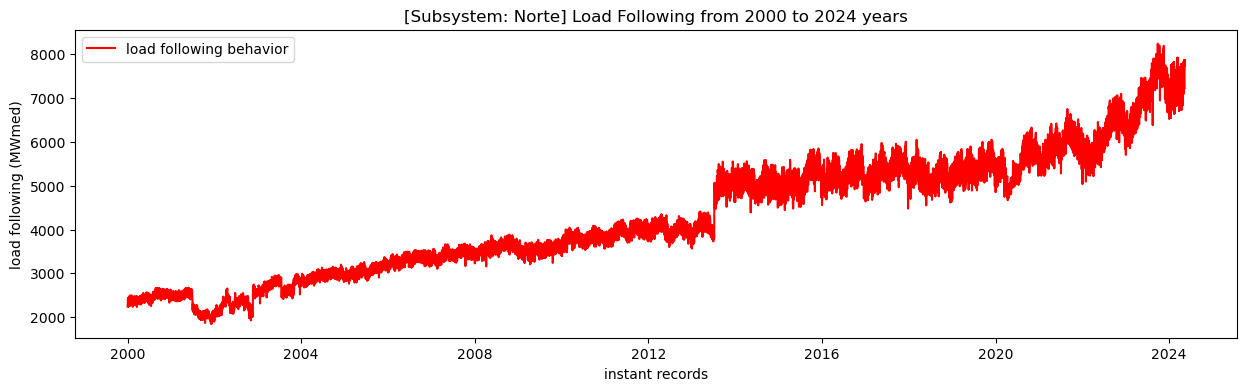

In [32]:
plt.figure(figsize=(15,4), dpi=100)
plt.plot(df['instant_record'], df['instant_load_following'], color='r', label='load following behavior')
plt.gca().set(
    title=f'[Subsystem: {SUBSYSTEM_NAME}] Load Following from {all_years[0]} to {all_years[-1]} years',
    xlabel="instant records",
    ylabel="load following (MWmed)"
)
plt.legend()
plt.show()

In [30]:
total_period: timedelta = last_instant_record.year - first_instant_record.year
total_period

24

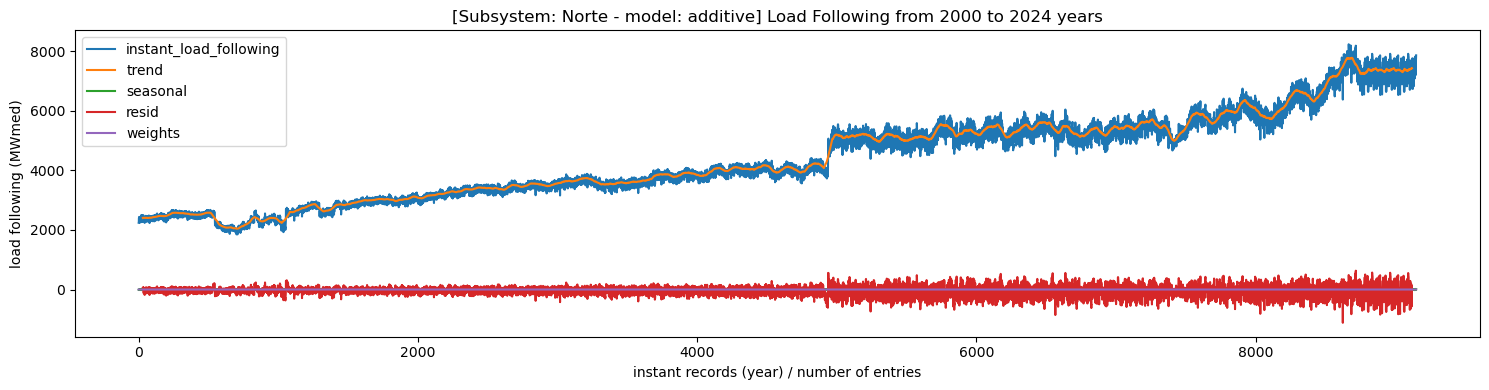

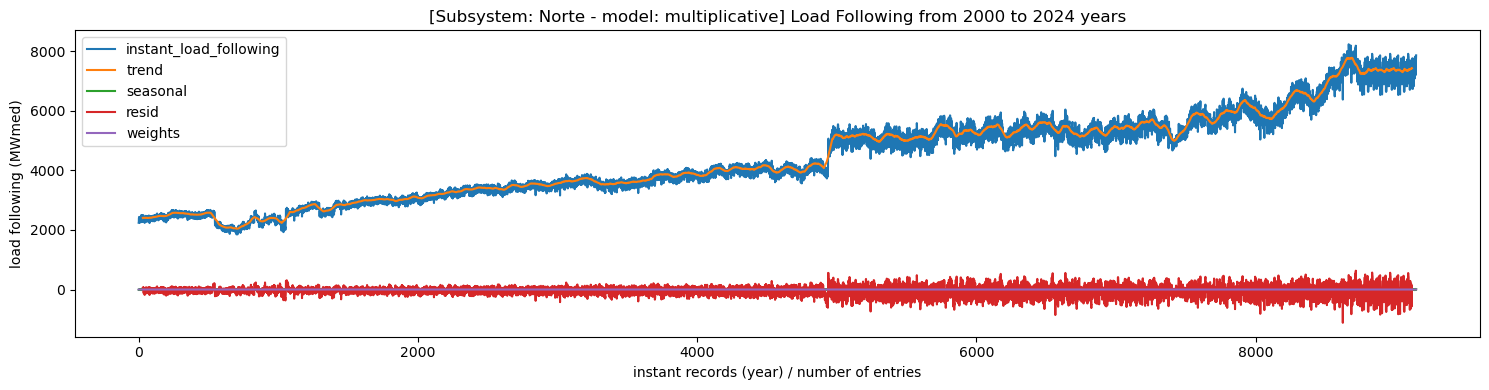

In [158]:
for decomposition_model in ['additive', 'multiplicative']:
    plt.figure(figsize=(15,4), dpi=100)
    
    decomposition = seasonal_decompose(df['instant_load_following'], model='decomposition_model', period=60)

    plt.title(f'[Subsystem: {SUBSYSTEM_NAME} - model: {decomposition_model}] Load Following from {all_years[0]} to {all_years[-1]} years')
    plt.xlabel("instant records (year) / number of entries")
    plt.ylabel("load following (MWmed)")

    decomposition.observed.plot(legend=True)
    decomposition.trend.plot(legend=True)
    decomposition.seasonal.plot(legend=True)
    decomposition.resid.plot(legend=True)
    decomposition.weights.plot(legend=True)

    plt.tight_layout()
    
plt.show()